# Clustering Countries - Indirect Effects

In [1]:
%matplotlib notebook

from IPython.display import display_html 

from tools import Preprocessing, Clustering, benchClustering, plotBarh

import pandas as pd
import numpy as np

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
from scipy.cluster import hierarchy


from fancyimpute import KNN

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tl

import matplotlib as mpl
import matplotlib.pyplot as plt
import bqplot as bqp
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pylab

import ipyvolume as ipv
from ipywidgets import FloatSlider, ColorPicker, VBox, jslink


sns.set(context='notebook', style='whitegrid', font='sans-serif',
        palette='muted', font_scale=1, color_codes=True, rc=None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 10000)

Using TensorFlow backend.


In [2]:
# import the csv dataset as a pandas DataFrame
# df = pd.read_csv('data/full_data.csv')
#df.columns
# list(df.columns)

"**Indirect effects** occur to industries in the backward­linked industries that supply the exporting firm." [Wayne P. Miller]

So, what does the indirect economic impact of an **off-shore oil platform** depends upon?


1. **Development of the oil sector** of the country
     - Hp: the more developed the  oil industry is, the higher the availability of specialized suppliers
     
 
2. **Industrial development of the country**
     - Hp: the more industrialized the country is, the higher the likelihood that suppliers will source locally
     
 
3. Level of **import** of goods and services
     - Hp: the more the country is open to import, the lower the likelihood that suppliers will source locally

### Variabili di aggregazione

1. Production of Oil, 2016 [bdp] 
2. Import of Goods and Services w.r.t. GDP, 2014-2016 average
3. MVAsh : GDP's share of Manufactoring Value Added , 2015

All these variables have been standardized for clustering.

In [3]:
varlist = [
    'Production_Oil_bpd_2016',
    'ImportGoodsServices_%GDP',
    'MVAsh%_2015',
#    'MVApc_constantUS$_2015',
#   'Production_Oil_bpd_2014',
#   'Production_Oil_bpd_2015',
#   'MHMVAsh%_2015', ???
          ]

In [4]:
prep = Preprocessing('data/full_data.csv',
                     varlist=varlist, verbose=True)
prep.exportCSV('data/cleaned_data_petroleum.csv', impute=True)

MISSING VALUES FOR EACH FEATURE:
MVAsh%_2015                 3
ImportGoodsServices_%GDP    1
dtype: int64 

MISSING VALUES FOR EACH COUNTRY:
Country Code
TKM    2
TLS    1
LBY    1
dtype: int64


Let's visualize our dataset a bit:

<IPython.core.display.Javascript object>


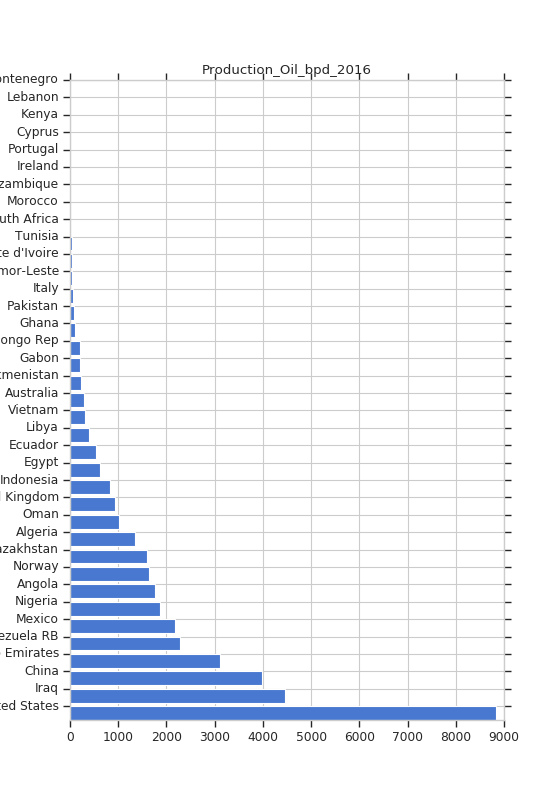

<IPython.core.display.Javascript object>


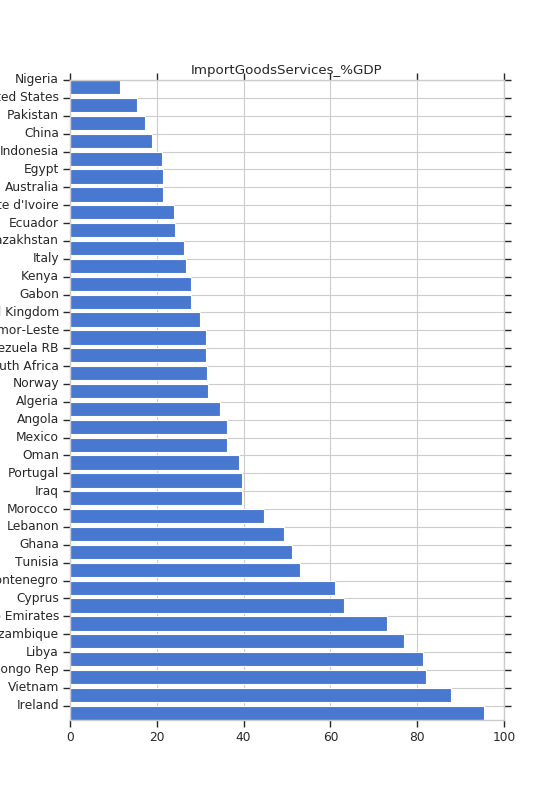

<IPython.core.display.Javascript object>


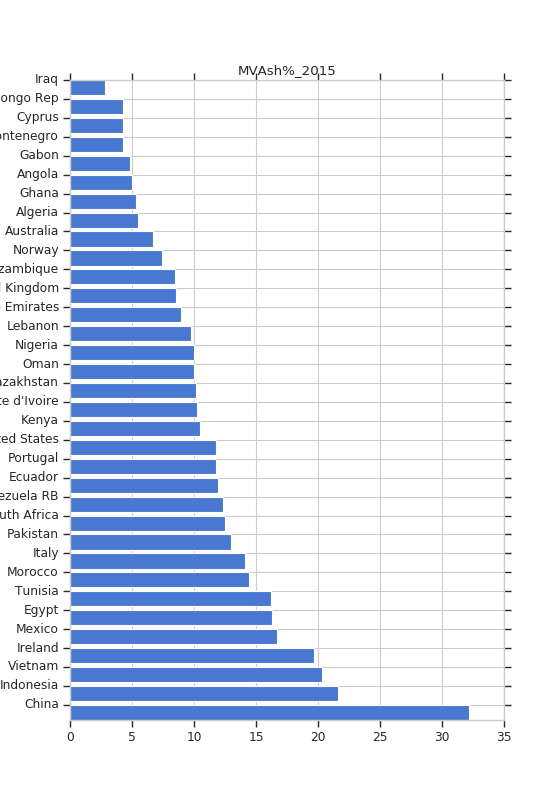

In [5]:
for c in prep.df.columns[1:]:
    plotBarh(df=prep.df, by_column=c )

In [6]:
data = Clustering('data/cleaned_data_petroleum.csv', verbose=False)

In [7]:
x = data.df.iloc[:, 0]
y = data.df.iloc[:, 1]
z = data.df.iloc[:, 2]

selected = None
ipv.figure()
scatter = ipv.pylab.scatter(x, y, z, marker="sphere", color = 'red', size=5, size_selected=8, selected=selected)
# ipv.pylab.xyzlabel(x.name, y.name, z.name)

size = FloatSlider(min=0, max=30, step=0.1)
size_selected = FloatSlider(min=0, max=30, step=0.1)
color = ColorPicker()
color_selected = ColorPicker()
jslink((scatter, 'size'), (size, 'value'))
jslink((scatter, 'size_selected'), (size_selected, 'value'))
jslink((scatter, 'color'), (color, 'value'))
jslink((scatter, 'color_selected'), (color_selected, 'value'))

In [8]:
print('x = ', x.name)
print('y = ', y.name)
print('z = ', z.name)
VBox([ipv.gcc(), size, size_selected, color, color_selected])

x =  Production_Oil_bpd_2016
y =  ImportGoodsServices_%GDP
z =  MVAsh%_2015


CUMULATIVE PROPORTION OF VARIANCE EXPLAINED BY PCs


<IPython.core.display.Javascript object>


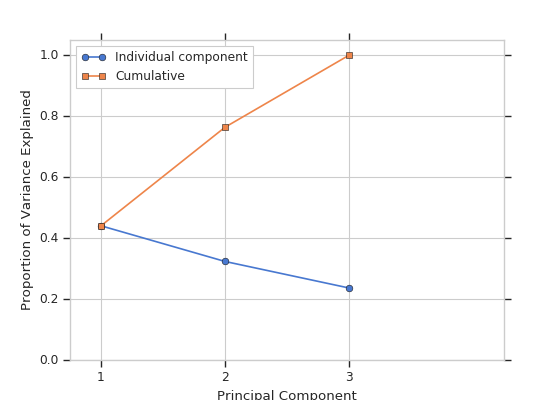

<IPython.core.display.Javascript object>


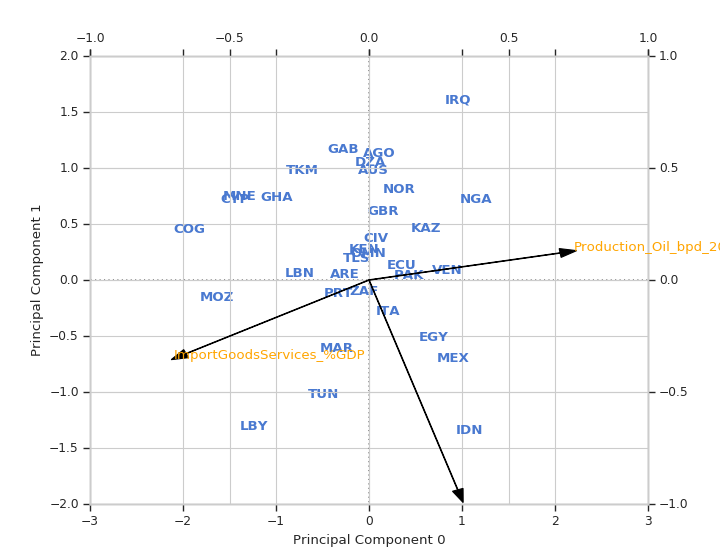

In [9]:
data.getPC()
data.plotAlongPC(pc1=0, pc2=1, xlim=[-3, 3], ylim=[-2, 2], loadings=True, clustering=None)

Let's implement various clustering techniques and compare their results:
 - **K-Means CLustering** (spherical clusters, fixed number)
 - **Hierarchical Agglomerative Clustering** (spherical clusters, adaptive)
 - **Gaussian Mixtures Model** (elliptical clusters, fixed number)
 - **Bayesian Gaussian Mixtures Model** (elliptical clusters, adaptive)

Some more information on the clustering techniques:

- **K-Means CLustering** : clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. 
- **Ward Hierarchical Clustering** : minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
- **Gaussian Mixtures Model** : a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.
- **Bayesian Gaussian Mixtures Model** : implements a variant of the Gaussian mixture model with variational inference algorithms. 

![caption](files/comparing_clustering_methods.png)

<IPython.core.display.Javascript object>


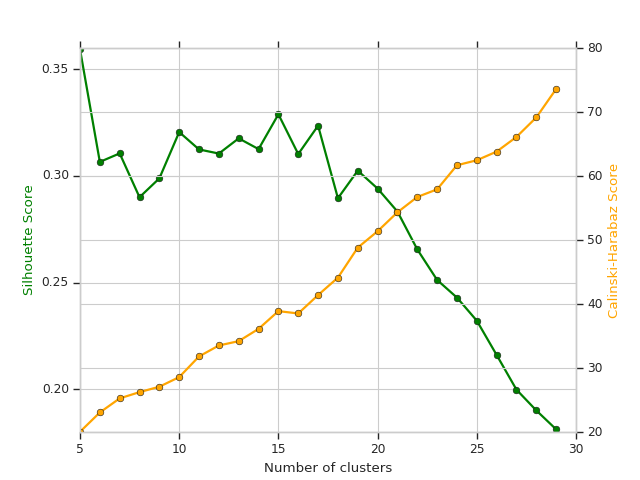

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:519: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



In [19]:
on_PC = 0
n_init = 100
k_min = 5
k_max = 30
silh, calha = data.multipleKmeans(k_min=5, k_max=30, on_PC=0, n_init=n_init)

In [20]:
k_clusters = 15
data.kmeans(n_clusters=k_clusters, on_PC=on_PC, n_init=n_init)
k_clusters = 10
data.kmeans(n_clusters=k_clusters, on_PC=on_PC, n_init=n_init)
# data.clusterings['kmeans'+str(n_clusters)]

the minimum BIC is achieved with               23 gaussian components


<IPython.core.display.Javascript object>


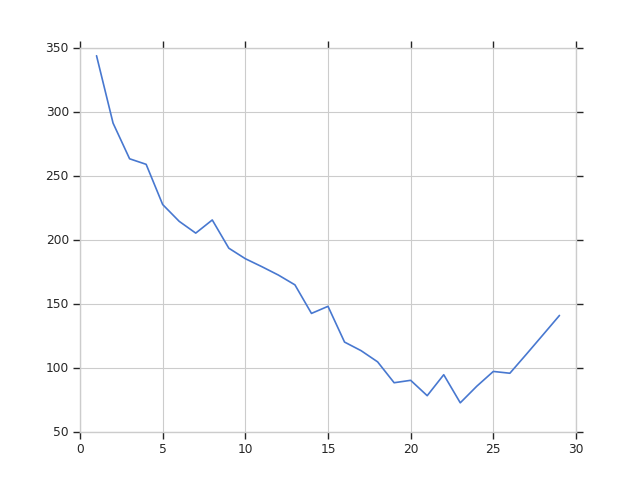

In [21]:
data.gmBIC(n_min=5, n_max=30, covariance_type='full', n_init=n_init, on_PC=on_PC)

In [13]:
n_components = 19
data.gaussianMixture(n_components, covariance_type='full', n_init=n_init, on_PC=0)
data.bayesianGaussianMixture(n_components, covariance_type='full', n_init=n_init, on_PC=0)

<IPython.core.display.Javascript object>


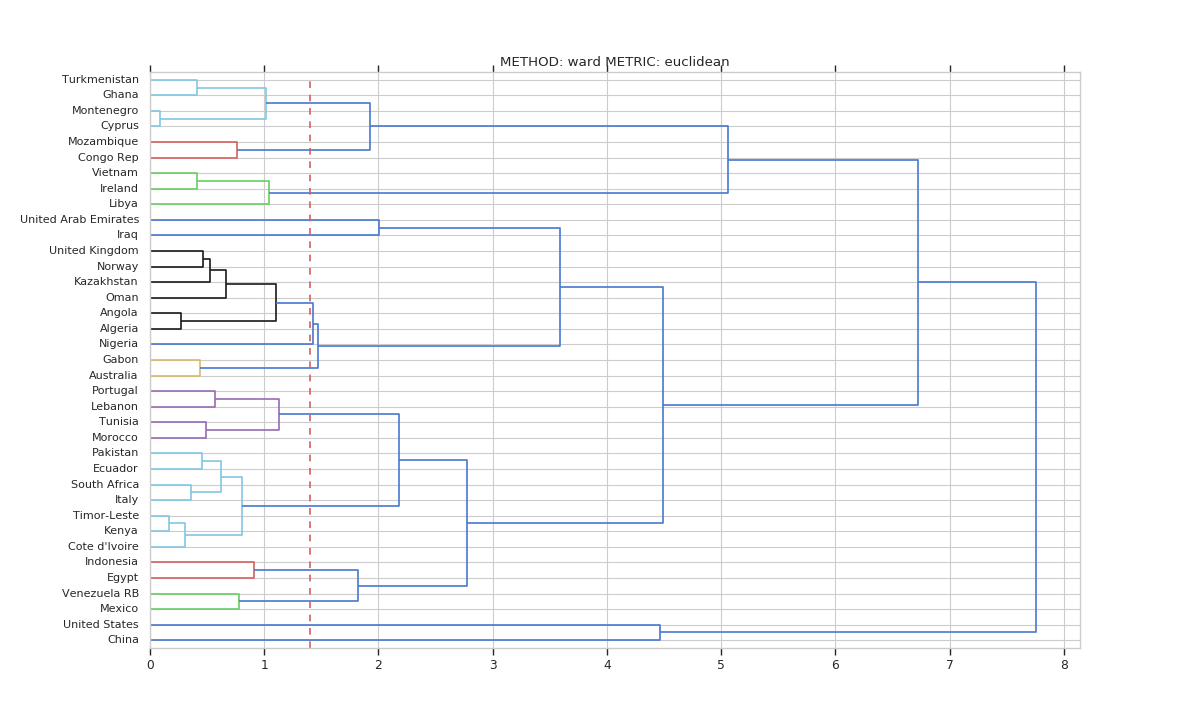

In [14]:
data.hierarchicalClustering(metric='euclidean', method='ward', threshold=1.4, on_PC=0, heatmap=False)

<IPython.core.display.Javascript object>


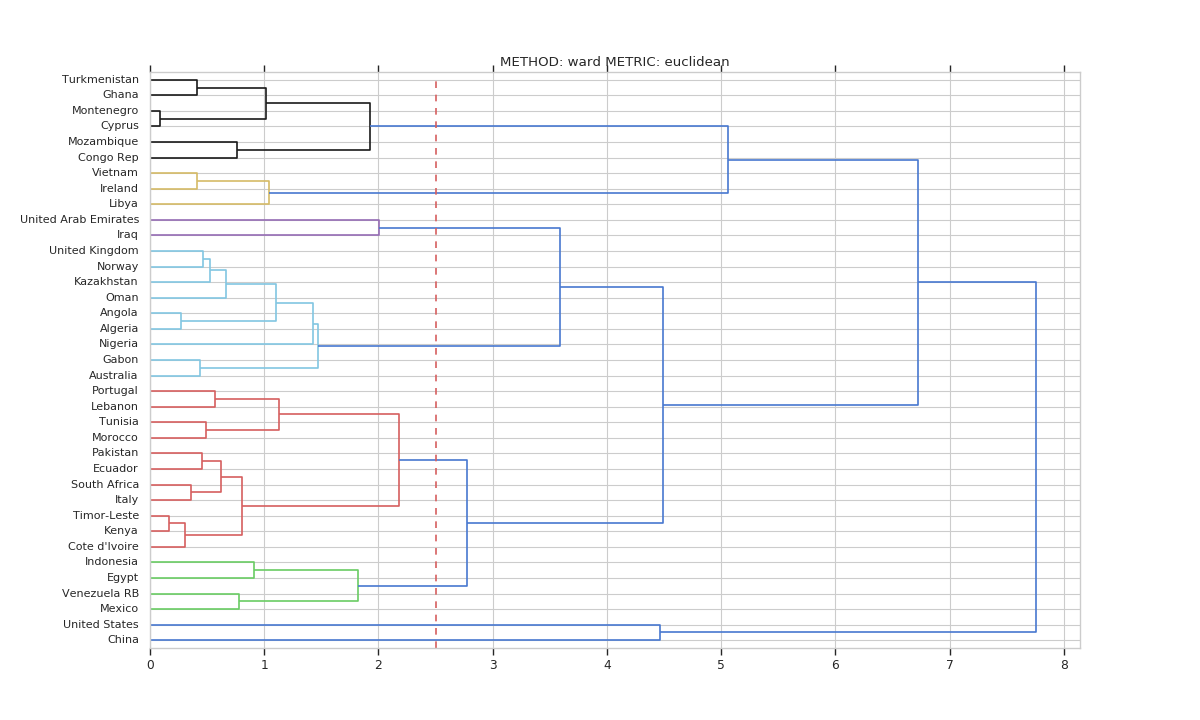

In [15]:
data.hierarchicalClustering(metric='euclidean', method='ward', threshold=2.5, on_PC=0, heatmap=False)

<IPython.core.display.Javascript object>


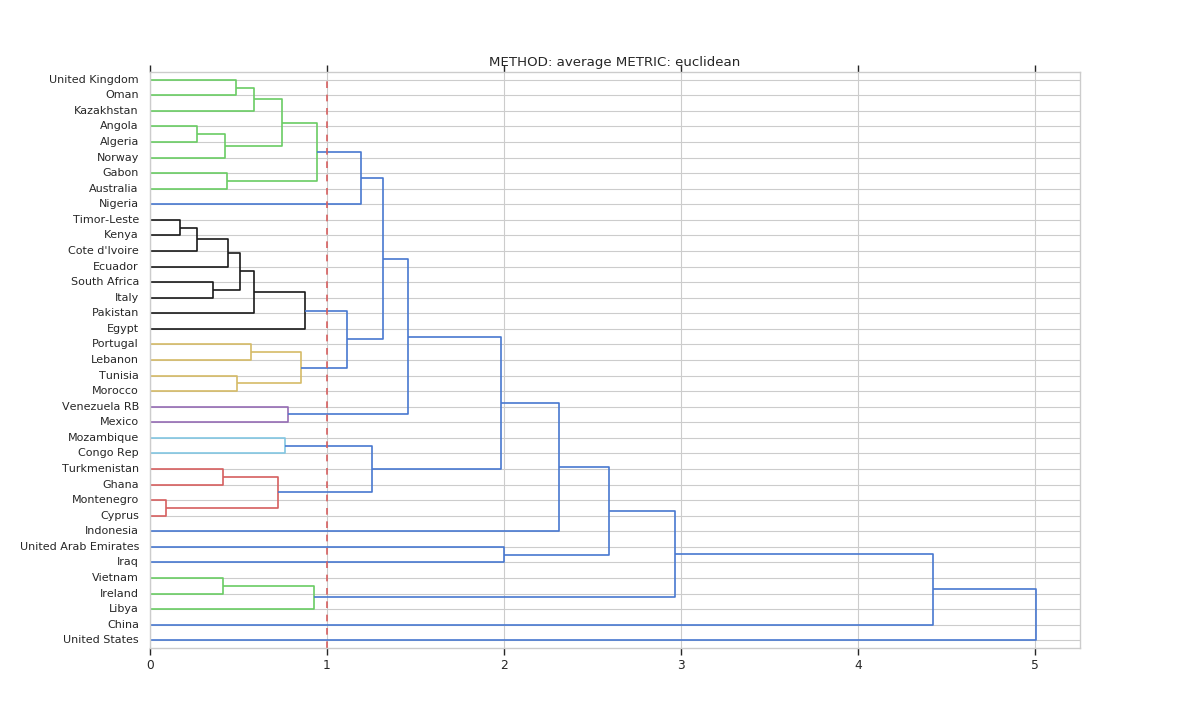

In [16]:
data.hierarchicalClustering(metric='euclidean', method='average', threshold=1, on_PC=0, heatmap=False)

In [17]:
#data.hierarchicalClustering(metric='euclidean', method='complete', threshold=1.5, on_PC=on_PC, heatmap=False)

After the analysis of:
- the best **number of clusters** for K-Means and the Gaussian Mixture Model
- the best **linkage methods and thresholds** for Hierarchical Clustering

The following clusterings have been computed:

In [18]:
sorted(data.clusterings_labels.keys())

['bayesian gm19',
 'gm19',
 'hc_average_euclidean_1',
 'hc_ward_euclidean_1.4',
 'hc_ward_euclidean_2.5',
 'kmeans10',
 'kmeans15']

In [172]:
# Compare multiple clusterings through 3D plotting

fig = tl.make_subplots(rows=4, cols=2,
                          print_grid=False,
                          specs=[[{'is_3d': True}, {'is_3d': True}],
                                 [{'is_3d': True}, {'is_3d': True}],
                                 [{'is_3d': True}, {'is_3d': True}],
                                 [{'is_3d': True}, None]])

X = data.df.values

fignum = 1
row = 1
for name, labels in data.clusterings_labels.items():
    # generate 3D scatter plot
    trace = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2],
                         hovertext=data.country_names,
                         name=name,
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                             cauto=True,
                             color=labels.astype(np.float),
                             colorscale='Rainbow',
                             opacity=0.99999999999999),
                         hoverlabel=dict(bgcolor='red'))
    col = abs(fignum % 2 - 2)
    # print('name: ', name, 'fignum=', fignum, 'row=',row,'col=',col)
    # append plot to the list
    fig.append_trace(trace, row=row, col=col)
    # update indices
    if fignum % 2 == 0:
        row += 1
    fignum = fignum + 1


fig['layout'].update(height=2000, width=1000)

# set titles to subplots
titles = list(data.clusterings_labels.keys())
fig['layout']['scene'].update(annotations=[dict(z=4, text=titles[0], showarrow=False)])
fig['layout']['scene2'].update(annotations=[dict(z=4, text=titles[1], showarrow=False)])
fig['layout']['scene3'].update(annotations=[dict(z=4, text=titles[2], showarrow=False)])
fig['layout']['scene4'].update(annotations=[dict(z=4, text=titles[3], showarrow=False)])
fig['layout']['scene5'].update(annotations=[dict(z=4, text=titles[4], showarrow=False)])
fig['layout']['scene6'].update(annotations=[dict(z=4, text=titles[5], showarrow=False)])
fig['layout']['scene7'].update(annotations=[dict(z=4, text=titles[6], showarrow=False)])
#fig['layout']['scene8'].update(annotations=[dict(z=4, text=titles[7], showarrow=False)])


Visual comparison of the clusters:

In [175]:
methods = list(data.clusterings_labels.keys())
n_clusters = [len(np.unique(x)) for x in data.clusterings_labels.values()]
ndf = pd.DataFrame(data=list(zip(methods, n_clusters)), columns=['Methods','N.clusters']).set_index('Methods')

In [176]:
from IPython.display import display
display(ndf)
print('\nx = ', data.df.columns[0])
print('y = ', data.df.columns[1])
print('z = ', data.df.columns[2])
py.iplot(fig)

,N.clusters
Methods,
bayesian gm19,4
hc_average_euclidean_1,13
hc_ward_euclidean_1.4,14
kmeans15,15
kmeans10,10
gm19,19
hc_ward_euclidean_2.5,8



x =  Production_Oil_bpd_2016
y =  ImportGoodsServices_%GDP
z =  MVAsh%_2015


In [141]:
# data.plotAlongPC(pc1=0, pc2=1, xlim=[-3, 3], ylim=[-2, 2], loadings=True, clustering='kmeans10')

In [137]:
# display all tables of clusters generated by different methods together
# newdf = np.zeros(len(data.clusterings.keys()))
styler = []
for k in sorted(data.clusterings.keys()):
    styler.append(data.clusterings[k].style.set_table_attributes("style='display:inline'"))
display_html(styler[0]._repr_html_() + styler[1]._repr_html_() + styler[2]._repr_html_() + styler[3]._repr_html_() + styler[4]._repr_html_(), raw=True)

,bayesian gm19
Cluster,
0,"['Algeria', 'Angola', 'Australia', 'Congo Rep', ""Cote d'Ivoire"", 'Cyprus', 'Ecuador', 'Egypt', 'Gabon', 'Ghana', 'Indonesia', 'Italy', 'Kazakhstan', 'Kenya', 'Lebanon', 'Mexico', 'Montenegro', 'Morocco', 'Mozambique', 'Nigeria', 'Norway', 'Oman', 'Pakistan', 'Portugal', 'South Africa', 'Timor-Leste', 'Tunisia', 'Turkmenistan', 'United Kingdom', 'Venezuela RB']"
2,"['Ireland', 'Libya', 'Vietnam']"
3,"['Iraq', 'United Arab Emirates', 'United States']"
4,['China']
,gm19
Cluster,
0,"['Egypt', 'Italy', 'Pakistan']"
1,"['Congo Rep', 'Mozambique']"
2,"['Kazakhstan', 'Oman', 'United Kingdom']"


# HOVER CHE FUNZIONANO MA UN SOLO PLOT

In [ ]:
# import plotly.plotly as py
# import pandas as pd

# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/alpha_shape.csv')
# df.head()

# fig = tools.make_subplots(rows=2, cols=3,
#                           print_grid=True,
#                           specs=[[{'is_3d': True}, {'is_3d': True}, {'is_3d': True}],
#                                  [ {'is_3d': True, 'rowspan':1}, None, None]])
# fig = fig.to_dict()
# X = data.df.values

# fignum = 1
# content = []
# for name, labels in data.clusterings_labels.items():
    
#     scatter = dict(
#         mode = "markers",
#         name = name,
#         type = "scatter3d",    
#         x=X[:, 0], y=X[:, 1], z=X[:, 2],
#         marker=dict(
#              cauto=True,
#              color=labels.astype(np.float),
#              colorscale='Rainbow',
#              line=dict(color='black', width=1)),
#         hoverlabel=dict(bgcolor='orange'),
#         hovertext=data.country_names)
    
#     content.append(scatter)

# layout = dict(
#     title = '3d point clustering',
#     scene = dict(
#         xaxis = dict( zeroline=False ),
#         yaxis = dict( zeroline=False ),
#         zaxis = dict( zeroline=False ),
#     ))
# fig = go.Figure(data=content)
# # Use py.iplot() for IPython notebook
# py.iplot(fig, filename='3d point clustering')

In [ ]:
d_fig = fig.to_dict()
print(type(d_fig))
print(len(d_fig))
print(type(d_fig['data']))
print(len(d_fig['data']))